In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
#파일불러오기
sample_df = pd.read_csv("C:/KIM/KUBIG/contest/sample_submission.csv")
train_df= pd.read_csv("C:/KIM/KUBIG/contest/train.csv")
test_df= pd.read_csv("C:/KIM/KUBIG/contest/test.csv")

Columns
Y_class : 제품 품질 상태(Target)
0 : 적정 기준 미달 (부적합)
1 : 적합
2 : 적정 기준 초과 (부적합)
Y_Quality : 제품 품질 관련 정량적 수치
TIMESTAMP : 제품이 공정에 들어간 시각
LINE : 제품이 들어간 공정 LINE 종류('T050304','T050307','T100304','T010306','T010305')
PRODUCT_CODE : 제품의 CODE 번호('A_31', 'T_31', 'O_31')
X_1 ~ X_2875 : 공정 과정에서 추출되어 비식별화된 변수

In [7]:
display(sample_df)


,PRODUCT_ID,Y_Class
0,TEST_000,0
1,TEST_001,0
2,TEST_002,0
3,TEST_003,0
4,TEST_004,0
...,...,...
305,TEST_305,0
306,TEST_306,0
307,TEST_307,0
308,TEST_308,0


In [8]:
train_df.shape

(598, 2881)

In [9]:
test_df.head()

,PRODUCT_ID,TIMESTAMP,LINE,PRODUCT_CODE,X_1,X_2,X_3,X_4,X_5,X_6,...,X_2866,X_2867,X_2868,X_2869,X_2870,X_2871,X_2872,X_2873,X_2874,X_2875
0,TEST_000,2022-09-09 2:01,T100306,T_31,2.0,94.0,0.0,45.0,10.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,TEST_001,2022-09-09 2:09,T100304,T_31,2.0,93.0,0.0,45.0,11.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,TEST_002,2022-09-09 8:42,T100304,T_31,2.0,95.0,0.0,45.0,11.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,TEST_003,2022-09-09 10:56,T010305,A_31,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,TEST_004,2022-09-09 11:04,T010306,A_31,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 결측값 처리

In [10]:
#train data
#일부 결측값이 있는 열은 X의 평균으로 대체
col_train = ['PRODUCT_ID', 'Y_Class', 'Y_Quality', 'TIMESTAMP', 'LINE', 'PRODUCT_CODE']
train_df_excluded = train_df[col_train]
train_df_filtered = train_df.drop(columns = col_train) 
mean_train = train_df_filtered.mean()
train_df_perfect = train_df_filtered.fillna(mean_train)

#결측값만 있는 열 제외
train_df_perfect = train_df_perfect.dropna(axis=1)

#다시 합치기
train_df = pd.concat([train_df_excluded, train_df_perfect], axis = 1)
train_df.head()


,PRODUCT_ID,Y_Class,Y_Quality,TIMESTAMP,LINE,PRODUCT_CODE,X_1,X_2,X_3,X_4,...,X_2862,X_2863,X_2864,X_2865,X_2866,X_2867,X_2868,X_2869,X_2870,X_2871
0,TRAIN_000,1,0.533433,2022-06-13 5:14,T050304,A_31,2.409742,95.123209,0.0,45.0,...,189.0,383.0,368.296296,353.0,39.34,40.89,32.56,34.09,77.77,1.0
1,TRAIN_001,2,0.541819,2022-06-13 5:22,T050307,A_31,2.409742,95.123209,0.0,45.0,...,185.6,383.0,367.735849,353.0,38.89,42.82,43.92,35.34,72.55,1.0
2,TRAIN_002,1,0.531267,2022-06-13 5:30,T050304,A_31,2.409742,95.123209,0.0,45.0,...,165.5,383.0,367.320755,353.0,39.19,36.65,42.47,36.53,78.35,1.0
3,TRAIN_003,2,0.537325,2022-06-13 5:39,T050307,A_31,2.409742,95.123209,0.0,45.0,...,165.8,384.0,369.188679,353.0,37.74,39.17,52.17,30.58,71.78,1.0
4,TRAIN_004,1,0.531590,2022-06-13 5:47,T050304,A_31,2.409742,95.123209,0.0,45.0,...,182.6,383.0,367.351852,352.0,38.70,41.89,46.93,33.09,76.97,1.0


### EDA

In [11]:
# line에 따른 사용 변수 개수 확인

line_counts = train_df['LINE'].value_counts()
line_counts

LINE
T100304    175
T100306    174
T050304     78
T010306     70
T010305     59
T050307     42
Name: count, dtype: int64

,Y_Class,min,max
0,0,0.500856,0.525067
1,1,0.525086,0.534843
2,2,0.534951,0.578841


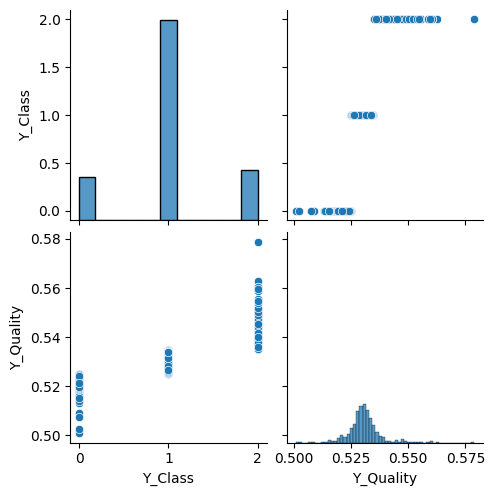

In [12]:
#class와 quality pairplot
col_train = ['Y_Class', 'Y_Quality','LINE', 'PRODUCT_CODE']
train_df_excluded = train_df[col_train]
sns.pairplot(data=train_df_excluded)

min_max_df = train_df.groupby('Y_Class')['Y_Quality'].agg(['min', 'max']).reset_index()
min_max_df
#quality에 따라 class가 구분

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_4964\534167623.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=train_df, x='LINE', y='Y_Quality', palette='Set2')


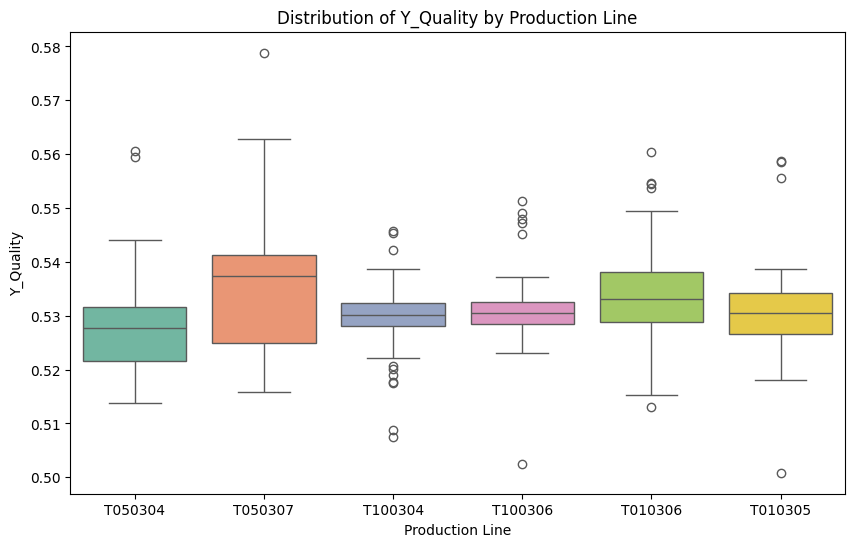

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_4964\534167623.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=train_df, x='LINE', y='Y_Class', palette='Set2')


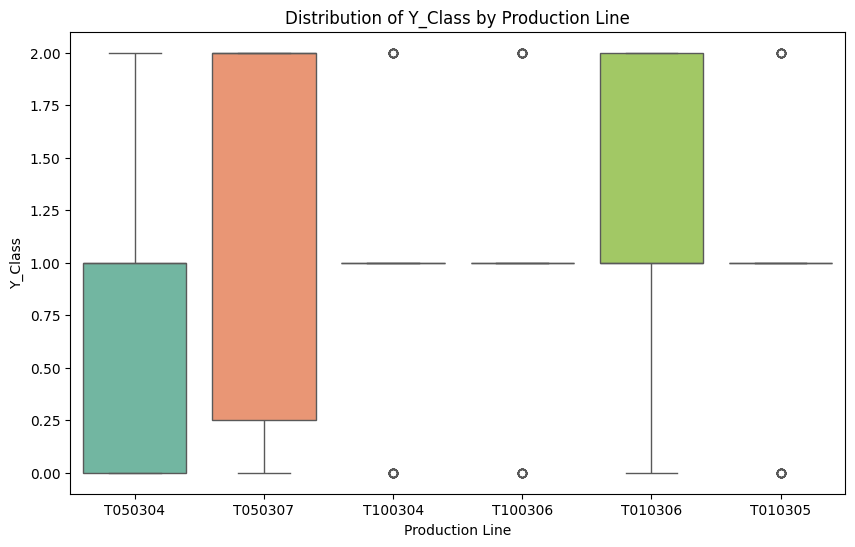

In [13]:
#라인 별 quality
plt.figure(figsize=(10, 6))
sns.boxplot(data=train_df, x='LINE', y='Y_Quality', palette='Set2')
plt.title('Distribution of Y_Quality by Production Line')
plt.xlabel('Production Line')
plt.ylabel('Y_Quality')
plt.show()

#라인 별 class
plt.figure(figsize=(10, 6))
sns.boxplot(data=train_df, x='LINE', y='Y_Class', palette='Set2')
plt.title('Distribution of Y_Class by Production Line')
plt.xlabel('Production Line')
plt.ylabel('Y_Class')
plt.show()

In [14]:
#라인별로 사용 개체의 개수가 비슷하다. 
#1위작품은 라인 3,4에 대해서밖에 안했지만 이 모델링에서 나머지 라인에 대해 분석을 한다면 의미가 있을 것이라 생각한다.
line1_train = train_df[(train_df['LINE'] == 'T100304') | (train_df['LINE'] == 'T100306')]
line2_train = train_df[(train_df['LINE'] == 'T050304') | (train_df['LINE'] == 'T050306') | (train_df['LINE'] == 'T010305') | (train_df['LINE'] == 'T050307')]
line1_train.head()

#LINE
#T100304    175
#T100306    174
#T050304     78
#T010306     70
#T010305     59
#T050307     42

#라인 개수별로 상위 두 개와 나머지 네 개를 묶었다.

,PRODUCT_ID,Y_Class,Y_Quality,TIMESTAMP,LINE,PRODUCT_CODE,X_1,X_2,X_3,X_4,...,X_2862,X_2863,X_2864,X_2865,X_2866,X_2867,X_2868,X_2869,X_2870,X_2871
22,TRAIN_022,0,0.517719,2022-06-14 8:53,T100304,T_31,2.0,102.0,0.0,45.0,...,163.290763,423.558233,406.088187,388.064257,50.8073,53.6077,49.6062,51.6598,66.6497,1.0
23,TRAIN_023,0,0.519090,2022-06-14 9:01,T100304,T_31,2.0,102.0,0.0,45.0,...,163.290763,423.558233,406.088187,388.064257,50.8073,53.6077,49.6062,51.6598,66.6497,1.0
25,TRAIN_025,1,0.529362,2022-06-19 9:11,T100304,T_31,2.0,97.0,0.0,45.0,...,163.290763,423.558233,406.088187,388.064257,50.8073,53.6077,49.6062,51.6598,66.6497,1.0
26,TRAIN_026,1,0.531992,2022-06-19 9:20,T100306,T_31,2.0,95.0,0.0,45.0,...,163.290763,423.558233,406.088187,388.064257,50.8073,53.6077,49.6062,51.6598,66.6497,1.0
29,TRAIN_029,1,0.532405,2022-06-19 23:31,T100304,T_31,2.0,100.0,0.0,45.0,...,163.290763,423.558233,406.088187,388.064257,50.8073,53.6077,49.6062,51.6598,66.6497,1.0


### 전처리

In [15]:
#x중 분산이 0인 열 및 nunique가 1인 열들 제거
variances1 = line1_train.iloc[:,6:].var()
cols_drop1 = variances1[variances1 == 0].index
line1_train = line1_train.drop(columns=cols_drop1)

unique_counts1 = line1_train.nunique()
cols_to_drop1 = unique_counts1[unique_counts1 == 1].index
line1_train_cleaned = line1_train.drop(columns=cols_to_drop1)


variances2 = line2_train.iloc[:,6:].var()
cols_to_drop2 = variances2[variances2 == 0].index
line2_train = line2_train.drop(columns=cols_to_drop2)

unique_counts2 = line2_train.nunique()
cols_to_drop2 = unique_counts2[unique_counts2 == 1].index
line2_train_cleaned = line2_train.drop(columns=cols_to_drop2)

line2_train_cleaned.head()

#line1에서 특히 많은 변수가 줄어 560개 가량이 남았고 line2에서도 많은 변수들이 줄어 1868개가 남았다.

,PRODUCT_ID,Y_Class,Y_Quality,TIMESTAMP,LINE,X_128,X_129,X_130,X_131,X_132,...,X_2861,X_2862,X_2863,X_2864,X_2865,X_2866,X_2867,X_2868,X_2869,X_2870
0,TRAIN_000,1,0.533433,2022-06-13 5:14,T050304,7813.000000,7813.000000,10904.333333,10904.333333,0.19,...,197.286667,189.0,383.0,368.296296,353.0,39.34,40.89,32.56,34.09,77.77
1,TRAIN_001,2,0.541819,2022-06-13 5:22,T050307,14699.833333,14791.923077,19854.000000,19854.000000,0.20,...,193.296552,185.6,383.0,367.735849,353.0,38.89,42.82,43.92,35.34,72.55
2,TRAIN_002,1,0.531267,2022-06-13 5:30,T050304,7815.000000,7815.000000,10904.333333,10904.333333,0.19,...,179.820690,165.5,383.0,367.320755,353.0,39.19,36.65,42.47,36.53,78.35
3,TRAIN_003,2,0.537325,2022-06-13 5:39,T050307,14699.833333,14791.923077,19856.000000,19856.000000,0.20,...,181.920690,165.8,384.0,369.188679,353.0,37.74,39.17,52.17,30.58,71.78
4,TRAIN_004,1,0.531590,2022-06-13 5:47,T050304,7817.000000,7817.000000,10904.333333,10904.333333,0.19,...,196.393333,182.6,383.0,367.351852,352.0,38.70,41.89,46.93,33.09,76.97


In [16]:
#변수 제거
drop_col1 = ['PRODUCT_ID', 'Y_Class','Y_Quality', 'TIMESTAMP', 'LINE', 'PRODUCT_CODE']
drop_col2 = ['PRODUCT_ID', 'Y_Class', 'Y_Quality', 'TIMESTAMP', 'LINE']
line1_train_drop = line1_train_cleaned.drop(columns = drop_col1)
line2_train_drop = line2_train_cleaned.drop(columns = drop_col2)
line1_train_drop.head()
#	PRODUCT_ID	Y_Class	Y_Quality	TIMESTAMP	LINE	PRODUCT_CODE

,X_1,X_2,X_5,X_7,X_8,X_9,X_11,X_12,X_13,X_15,...,X_924,X_925,X_926,X_927,X_928,X_929,X_930,X_931,X_932,X_933
22,2.0,102.0,11.0,45.0,10.0,31.0,514.4,522.1,505.8,0.0,...,172.500000,162.800000,157.235484,150.900000,326.000000,309.290909,290.000000,13.700000,13.443333,13.200000
23,2.0,102.0,11.0,45.0,10.0,31.0,514.6,522.6,506.0,0.0,...,173.048851,160.670402,154.242580,147.472126,323.215517,307.148037,291.494253,13.641092,13.409719,13.212069
25,2.0,97.0,11.0,45.0,10.0,31.0,517.4,526.0,508.9,0.0,...,177.800000,157.100000,154.074194,150.900000,327.000000,310.854546,298.000000,13.700000,13.454839,13.200000
26,2.0,95.0,10.0,54.0,10.0,52.0,477.4,482.4,470.2,0.0,...,166.900000,158.500000,151.096774,146.500000,327.000000,313.618182,299.000000,13.700000,13.461290,13.300000
29,2.0,100.0,11.0,45.0,10.0,31.0,516.5,526.0,507.5,0.0,...,177.900000,161.300000,156.038710,149.100000,327.000000,312.109091,298.000000,13.700000,13.422581,13.200000


In [17]:
#scaling 후 df로 바꾸고 병합하기
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
line1_train_scaled = scaler.fit_transform(line1_train_drop)
line2_train_scaled = scaler.fit_transform(line2_train_drop)

line1_train_scaled_df = pd.DataFrame(line1_train_scaled, columns=line1_train_drop.columns)
line2_train_scaled_df = pd.DataFrame(line2_train_scaled, columns=line2_train_drop.columns)

line1_train_scaled_df = line1_train_scaled_df.reset_index(drop=True)
line1_train = line1_train.reset_index(drop=True)
line1_train_scaled_df['Y_Class'] = line1_train['Y_Class']

line2_train_scaled_df = line2_train_scaled_df.reset_index(drop=True)
line2_train = line2_train.reset_index(drop=True)
line2_train_scaled_df['Y_Class'] = line2_train['Y_Class']

line1_train_scaled_df.head()

,X_1,X_2,X_5,X_7,X_8,X_9,X_11,X_12,X_13,X_15,...,X_925,X_926,X_927,X_928,X_929,X_930,X_931,X_932,X_933,Y_Class
0,-0.069603,1.676550,1.243964,-0.870577,-0.226285,-0.997139,1.006343,1.041738,1.010489,-0.053606,...,0.596240,0.964757,8.812935e-01,0.605077,4.930516e-01,-0.340756,1.057783e+00,6.495214e-01,-2.338850e-01,0
1,-0.069603,1.676550,1.243964,-0.870577,-0.226285,-0.997139,1.017944,1.069594,1.022043,-0.053606,...,0.000000,0.000000,7.307115e-15,0.000000,-1.307905e-14,0.000000,9.569148e-14,-3.432424e-14,-3.442410e-14,0
2,-0.069603,0.457558,1.243964,-0.870577,-0.226285,-0.997139,1.180358,1.259015,1.189570,-0.053606,...,-0.999632,-0.054279,8.812935e-01,0.822380,8.528272e-01,1.483599,1.057783e+00,8.718379e-01,-2.338850e-01,1
3,-0.069603,-0.030038,-0.803882,1.190073,-0.226285,1.002869,-1.139838,-1.170035,-1.046044,-0.053606,...,-0.607664,-1.014044,-2.499301e-01,0.822380,1.488710e+00,1.711644,1.057783e+00,9.965012e-01,1.704019e+00,1
4,-0.069603,1.188953,1.243964,-0.870577,-0.226285,-0.997139,1.128153,1.259015,1.108695,-0.053606,...,0.176273,0.578979,4.185202e-01,0.822380,1.141484e+00,1.483599,1.057783e+00,2.485209e-01,-2.338850e-01,1


In [18]:
#test셋 가공
line1_test = test_df[(test_df['LINE'] == 'T100304') | (test_df['LINE'] == 'T100306')]
line2_test = test_df[(test_df['LINE'] == 'T050304') | (test_df['LINE'] == 'T050306') | (test_df['LINE'] == 'T010305') | (test_df['LINE'] == 'T050307')]
line1_test.head()

,PRODUCT_ID,TIMESTAMP,LINE,PRODUCT_CODE,X_1,X_2,X_3,X_4,X_5,X_6,...,X_2866,X_2867,X_2868,X_2869,X_2870,X_2871,X_2872,X_2873,X_2874,X_2875
0,TEST_000,2022-09-09 2:01,T100306,T_31,2.0,94.0,0.0,45.0,10.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,TEST_001,2022-09-09 2:09,T100304,T_31,2.0,93.0,0.0,45.0,11.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,TEST_002,2022-09-09 8:42,T100304,T_31,2.0,95.0,0.0,45.0,11.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15,TEST_015,2022-09-20 5:20,T100304,T_31,2.0,102.0,0.0,45.0,11.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16,TEST_016,2022-09-20 5:28,T100306,T_31,2.0,93.0,0.0,45.0,10.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
#test set에서 model1에 쓰이는 변수만 추출
columns_drop1 = line1_train_scaled_df.drop(columns=['Y_Class'])
columns1 = columns_drop1.columns.tolist()
line1_test_selected = line1_test[columns1]
line1_test_selected.head()

columns_drop2 = line2_train_scaled_df.drop(columns=['Y_Class'])
columns2 = columns_drop2.columns.tolist()
line2_test_selected = line2_test[columns2]

all_nan_columns = line2_test_selected.columns[line2_test_selected.isna().all()]

print("Columns where all values are NaN:")
print(all_nan_columns)

Columns where all values are NaN:
Index(['X_1167', 'X_1168', 'X_1169', 'X_1170', 'X_1171', 'X_1274', 'X_1275',
       'X_1276', 'X_1277', 'X_1278',
       ...
       'X_2618', 'X_2619', 'X_2620', 'X_2621', 'X_2622', 'X_2623', 'X_2624',
       'X_2625', 'X_2626', 'X_2627'],
      dtype='object', length=492)


In [20]:
#test
#X의 평균으로 대체
mean_test1 = line1_test_selected.mean()
line1_test_perfect = line1_test_selected.fillna(mean_test1)

# 모든 값이 NaN인 열을 0으로 채우기
all_nan_columns1 = line1_test_perfect.columns[line1_test_perfect.isna().all()]
line1_test_perfect[all_nan_columns1] = 0

mean_test2 = line2_test_selected.mean()
line2_test_perfect = line2_test_selected.fillna(mean_test2)

# 모든 값이 NaN인 열을 0으로 채우기
all_nan_columns2 = line2_test_perfect.columns[line2_test_perfect.isna().all()]
line2_test_perfect[all_nan_columns2] = 0

print(line2_test_perfect.shape, line2_train_scaled_df.shape)

(53, 1863) (179, 1864)


In [21]:
#line1 data scaling 후 df로 바꾸고 병합하기
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

line1_train_scaled = scaler.fit_transform(line1_train_drop)
line1_test_scaled = scaler.transform(line1_test_perfect)

line1_train_scaled_df = pd.DataFrame(line1_train_scaled, columns=line1_train_drop.columns)
line1_test_scaled_df = pd.DataFrame(line1_test_scaled, columns = line1_test_perfect.columns)

line1_train_scaled_df = line1_train_scaled_df.reset_index(drop=True)
line1_train = line1_train.reset_index(drop=True)
line1_train_scaled_df['Y_Class'] = line1_train['Y_Class']

line1_train_scaled_df.head()

,X_1,X_2,X_5,X_7,X_8,X_9,X_11,X_12,X_13,X_15,...,X_925,X_926,X_927,X_928,X_929,X_930,X_931,X_932,X_933,Y_Class
0,-0.069603,1.676550,1.243964,-0.870577,-0.226285,-0.997139,1.006343,1.041738,1.010489,-0.053606,...,0.596240,0.964757,8.812935e-01,0.605077,4.930516e-01,-0.340756,1.057783e+00,6.495214e-01,-2.338850e-01,0
1,-0.069603,1.676550,1.243964,-0.870577,-0.226285,-0.997139,1.017944,1.069594,1.022043,-0.053606,...,0.000000,0.000000,7.307115e-15,0.000000,-1.307905e-14,0.000000,9.569148e-14,-3.432424e-14,-3.442410e-14,0
2,-0.069603,0.457558,1.243964,-0.870577,-0.226285,-0.997139,1.180358,1.259015,1.189570,-0.053606,...,-0.999632,-0.054279,8.812935e-01,0.822380,8.528272e-01,1.483599,1.057783e+00,8.718379e-01,-2.338850e-01,1
3,-0.069603,-0.030038,-0.803882,1.190073,-0.226285,1.002869,-1.139838,-1.170035,-1.046044,-0.053606,...,-0.607664,-1.014044,-2.499301e-01,0.822380,1.488710e+00,1.711644,1.057783e+00,9.965012e-01,1.704019e+00,1
4,-0.069603,1.188953,1.243964,-0.870577,-0.226285,-0.997139,1.128153,1.259015,1.108695,-0.053606,...,0.176273,0.578979,4.185202e-01,0.822380,1.141484e+00,1.483599,1.057783e+00,2.485209e-01,-2.338850e-01,1


In [22]:
#line2 data scaling 후 df로 바꾸기
scaler = StandardScaler()

line2_train_scaled = scaler.fit_transform(line2_train_drop)
line2_test_scaled = scaler.transform(line2_test_perfect)

line2_train_scaled_df = pd.DataFrame(line2_train_scaled, columns=line2_train_drop.columns)
line2_test_scaled_df = pd.DataFrame(line2_test_scaled, columns = line2_test_perfect.columns)

line2_train_scaled_df = line2_train_scaled_df.reset_index(drop=True)
line2_train = line2_train.reset_index(drop=True)
line2_train_scaled_df['Y_Class'] = line2_train['Y_Class']

line2_test_scaled_df.head()

,X_128,X_129,X_130,X_131,X_132,X_133,X_134,X_136,X_137,X_138,...,X_2861,X_2862,X_2863,X_2864,X_2865,X_2866,X_2867,X_2868,X_2869,X_2870
0,-0.212705,-0.231244,0.75856,1.767462,2.213789,2.375148,2.086909,0.617028,0.614069,0.588731,...,1.569408,1.646944,1.628836,1.502914,1.436685,0.241469,-0.097969,0.072917,0.383576,-0.844457
1,-0.212705,-0.231244,0.75856,1.767462,2.213789,2.375148,2.086909,0.617028,0.614069,0.588731,...,1.844003,0.909682,1.544529,1.528348,1.436685,0.241469,-0.097969,0.072917,0.383576,-0.844457
2,0.612619,0.599841,0.75856,1.767462,-1.421940,-1.829254,-1.114924,-0.171719,-0.172369,-0.171097,...,1.507897,0.333432,-0.703657,-0.649177,-0.609970,1.329475,-0.181352,0.909804,0.954991,-1.036356
3,0.618688,0.605952,0.75856,1.767462,-1.421940,-1.829254,-1.114924,-0.167224,-0.172369,-0.166602,...,0.701004,0.460546,-0.703657,-0.626244,-0.639631,0.455010,0.398538,-1.468105,-0.561179,-1.760976
4,-0.212705,-0.231244,0.75856,1.767462,2.213789,2.375148,2.086909,0.617028,0.614069,0.588731,...,1.418335,0.850363,1.600733,1.500699,1.436685,0.241469,-0.097969,0.072917,0.383576,-0.844457


In [23]:
#정수형인 Y_Class를 범주형으로 바꾸기
line1_train_scaled_df['Y_Class'] = line1_train_scaled_df['Y_Class'].astype('category')
line2_train_scaled_df['Y_Class'] = line2_train_scaled_df['Y_Class'].astype('category')

### H2O AUTO ML

In [24]:
#h2o auto ml
import h2o

h2o.init()

#train set, test set h2o로 바꾸기
line1_train_h2o = h2o.H2OFrame(line1_train_scaled_df)
line2_train_h2o = h2o.H2OFrame(line2_train_scaled_df)
line1_test_h2o = h2o.H2OFrame(line1_test_scaled_df)
line2_test_h2o = h2o.H2OFrame(line2_test_scaled_df)




Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.411-b09, mixed mode)
  Starting server from C:\Users\13wog\AppData\Local\Programs\Python\Python312\Lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\Public\Documents\ESTsoft\CreatorTemp\tmpr211anw2
  JVM stdout: C:\Users\Public\Documents\ESTsoft\CreatorTemp\tmpr211anw2\h2o_KIM_started_from_python.out
  JVM stderr: C:\Users\Public\Documents\ESTsoft\CreatorTemp\tmpr211anw2\h2o_KIM_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,05 secs
H2O_cluster_timezone:,Asia/Seoul
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.4
H2O_cluster_version_age:,1 month and 14 days
H2O_cluster_name:,H2O_from_python_KIM_qyxoal
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.420 Gb
H2O_cluster_total_cores:,0
H2O_cluster_allowed_cores:,0
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [25]:
line1_train_h2o['Y_Class'] = line1_train_h2o['Y_Class'].asfactor()
line2_train_h2o['Y_Class'] = line2_train_h2o['Y_Class'].asfactor()


### LINE1 MODELING(PCA 고려X)

In [26]:
#line1의 bestmodel찾기
from h2o.automl import H2OAutoML

aml = H2OAutoML(max_runtime_secs=120, seed=42, exclude_algos=None, include_algos= None)
aml.train(y='Y_Class', training_frame = line1_train_h2o)

AutoML progress: |
19:36:45.542: AutoML: XGBoost is not available; skipping it.

███
19:36:52.388: GLM_1_AutoML_1_20240824_193645 [GLM def_1] failed: java.lang.ArrayIndexOutOfBoundsException: 554

████████████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OGradientBoostingEstimator : Gradient Boosting Machine
Model Key: GBM_5_AutoML_1_20240824_193645


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    30                 90                          28331                  6            6            6             8             43            20.4444

ModelMetricsMultinomial: gbm
** Reported on train data. **

MSE: 0.010537999269547023
RMSE: 0.10265475765665721
LogLoss: 0.0776528832309924
Mean Per-Class Error: 0.0
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
0    1    2    Error    Rate
---  ---  ---  -------  -------
28   0    0    0        0 / 28
0    289  0    0        0 / 289
0    0    32   0        0 / 32
28   289  32   0        0 / 349

Top-3 Hit Ratios: 
k    hit_ratio
---  -----------
1    1
2    1
3    1

ModelMetricsMultinomial: gbm
** Reported on cross-validation data. **

MSE: 0.13722035814483394
RMSE: 0.3704326634421348
LogLoss: 0.5150534957293395
Mean Per-Class Error: 0.536198302850552
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
0    1    2    Error      Rate
---  ---  ---  ---------  --------
6    21   1    0.785714   22 / 28
0    286  3    0.0103806  3 / 289
1    25   6    0.8125     26 / 32
7    332  10   0.146132   51 / 349

Top-3 Hit Ratios: 
k    hit_ratio
---  -----------
1    0.853868
2    0.942693
3    1

Cross-Validation Metrics Summary: 
                         mean      sd         cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid
-----------------------  --------  ---------  ------------  ------------  ------------  ------------  ------------
accuracy                 0.856894  0.0861034  0.914286      0.785714      0.928571      0.742857      0.913044
aic                      nan       0          nan           nan           nan           nan           nan
auc                      nan       0          nan           nan           nan           nan           nan
err                      0.143106  0.0861034  0.0857143     0.214286      0.0714286     0.257143      0.0869565
err_count                10        6.04152    6             15            5             18            6
loglikelihood            nan       0          nan           nan           nan           nan           nan
logloss                  0.558243  0.280049   0.39877       0.714009      0.331568      0.978473      0.368399
max_per_class_error      0.843333  0.150739   0.666667      1             0.8           1             0.75
mean_per_class_accuracy  0.521363  0.15014    0.611111      0.407407      0.728042      0.360256      0.5
mean_per_class_error     0.478637  0.15014    0.388889      0.592593      0.271958      0.639744      0.5
mse                      0.138245  0.0717411  0.0964247     0.185061      0.0814742     0.24186       0.0864051
pr_auc                   nan       0          nan           nan           nan           nan           nan
r2                       0.207939  0.100329   0.321148      0.237342      0.170014      0.0564364     0.254756
rmse

In [27]:
#최적의 모델(모든 x를 포함했을 때)
best_model = aml.leader
print(best_model)

Model Details
H2OGradientBoostingEstimator : Gradient Boosting Machine
Model Key: GBM_5_AutoML_1_20240824_193645


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    30                 90                          28331                  6            6            6             8             43            20.4444

ModelMetricsMultinomial: gbm
** Reported on train data. **

MSE: 0.010537999269547023
RMSE: 0.10265475765665721
LogLoss: 0.0776528832309924
Mean Per-Class Error: 0.0
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_typ

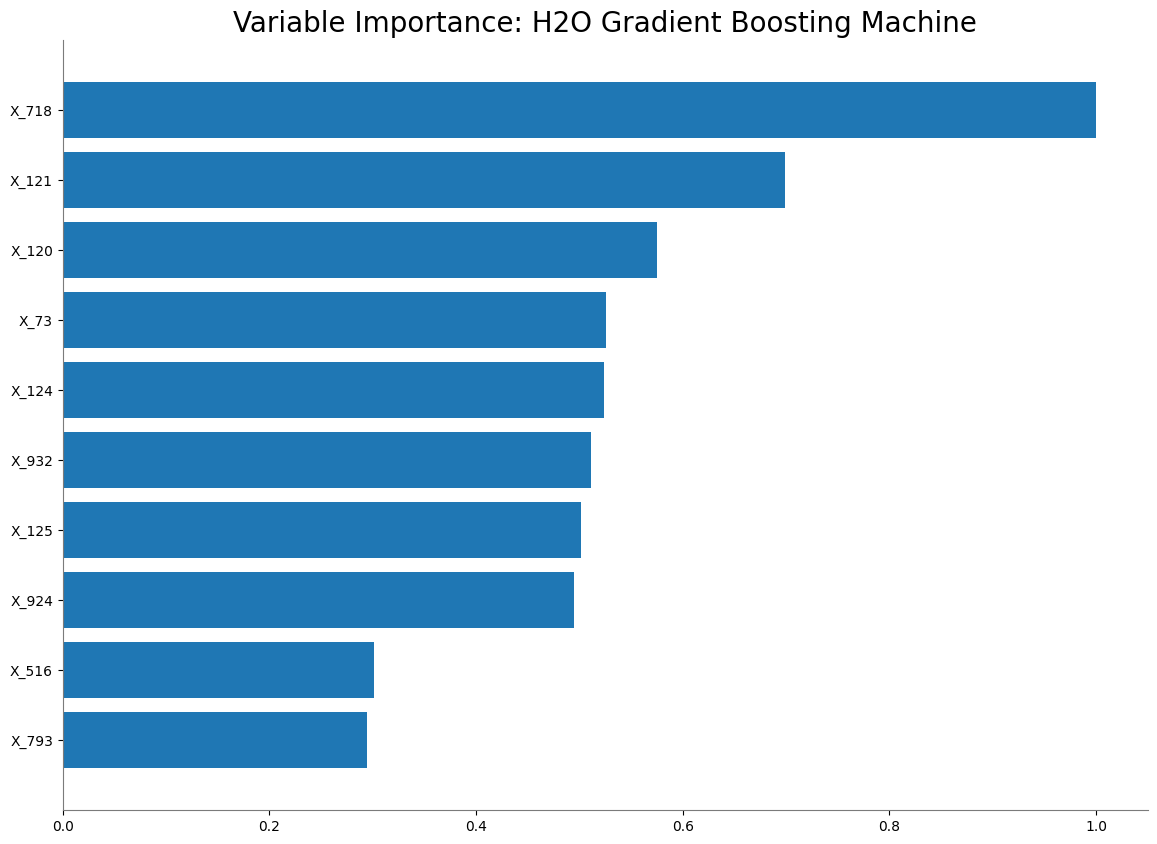

<Figure size 640x480 with 0 Axes>

In [28]:
#변수의 중요도 파악
var_importance = best_model.varimp_plot()
plt.show()

In [29]:
#test set을 model에 적합
predictions = best_model.predict(line1_test_h2o)
predictions

gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


predict,p0,p1,p2
1,0.022633,0.885558,0.0918088
1,0.0547225,0.764958,0.180319
1,0.0382008,0.904845,0.0569545
1,0.0438293,0.935661,0.0205098
1,0.0404628,0.938135,0.0214019
1,0.0259856,0.951394,0.0226208
1,0.0248987,0.946859,0.0282423
1,0.0473386,0.849872,0.10279
1,0.0182153,0.954371,0.0274133
1,0.0248785,0.860729,0.114393


In [30]:
#predict를 line1_test_h2o에 합치기
line1_test_h2o['Y_Class'] = predictions['predict']
line1_test_h2o

X_1         X_2        X_5        X_7        X_8        X_9       X_11       X_12       X_13        X_15       X_16       X_17       X_18       X_20       X_21       X_22       X_24       X_38     X_39       X_40       X_41       X_42      X_43       X_44       X_45       X_46       X_47       X_48       X_49       X_50        X_51       X_52       X_53       X_54       X_55       X_56        X_57        X_58       X_59      X_60       X_61       X_62      X_63       X_64       X_65         X_66      X_73       X_86       X_87       X_88       X_90       X_94       X_95      X_97       X_98       X_99      X_101      X_102      X_103       X_105      X_106      X_107       X_109       X_110      X_111      X_113      X_114      X_115     X_117      X_118      X_119      X_120      X_121      X_123       X_124       X_125      X_126      X_127     X_384     X_385     X_386      X_387       X_388       X_389      X_393      X_394      X_395      X_396      X_397       X_398       X_399     X_400     X_401     X_402      X_403      X_404      X_405      X_406      X_407     X_408      X_412      X_413      X_414      X_415      X_416      X_417       X_418       X_419       X_420      X_421       X_422       X_423       X_428      X_435       X_436      X_437         X_438      X_439       X_440      X_441      X_442      X_443      X_444     X_445      X_446      X_447     X_448      X_449      X_450      X_451      X_452      X_453      X_454     X_455      X_456     X_457     X_458     X_459      X_460       X_461      X_462      X_463      X_464     X_465     X_468      X_469      X_470      X_471       X_472      X_473        X_474       X_475      X_476      X_477     X_478      X_479         X_480     X_481     X_482      X_483      X_484     X_485      X_486       X_488       X_489       X_490       X_491    X_492       X_493       X_494      X_495       X_496     X_497     X_498       X_499      X_500       X_501      X_502       X_504       X_506       X_507     X_509       X_510     X_511     X_513    X_514      X_515      X_516      X_517      X_518      X_520       X_521      X_522      X_523        X_524      X_525      X_526       X_527       X_528     X_529     X_530     X_531    X_532     X_533      X_534      X_535        X_536      X_537      X_538      X_539      X_540      X_541      X_542      X_543       X_544      X_545       X_546      X_547      X_548      X_549      X_550        X_551      X_552       X_553      X_554      X_555      X_556      X_557      X_559      X_560      X_562      X_563      X_564      X_565      X_566      X_568    X_569      X_570        X_571      X_572       X_573      X_574      X_575      X_576      X_577       X_578     X_579      X_580       X_581       X_582      X_584      X_585      X_586       X_587       X_588      X_589      X_590      X_591      X_592      X_593       X_594      X_595      X_596      X_597      X_598      X_599     X_600     X_601    X_602     X_603     X_604      X_605      X_606      X_607      X_608     X_609      X_610      X_611      X_612      X_613       X_614      X_615       X_616      X_618      X_619      X_621      X_622      X_623      X_624      X_625      X_626      X_627       X_628     X_629      X_630       X_632      X_635      X_637       X_643     X_644     X_645       X_646      X_647       X_648      X_649     X_651       X_652       X_653       X_654       X_655       X_656       X_657        X_658       X_659       X_660       X_661      X_662        X_663      X_664       X_665      X_666        X_667      X_668        X_669      X_670      X_671      X_674      X_675       X_677      X_678      X_679      X_680      X_681      X_682      X_683      X_684       X_685      X_686       X_687      X_688      X_689      X_690      X_693      X_694      X_696     X_697      X_698     X_699      X_700      X_701      X_702      X_703      X_704      X_705      X_706      X_707      X_708     X_709     X_710     X_711     X_712  

### LINE2 BEST MODEL(PCA 고려X)

In [31]:
#line2의 bestmodel찾기
from h2o.automl import H2OAutoML
aml2 = H2OAutoML(max_runtime_secs=120, seed=42,exclude_algos=None, include_algos= None)
aml2.train(y='Y_Class', training_frame = line2_train_h2o)


AutoML progress: |
19:38:48.335: AutoML: XGBoost is not available; skipping it.

██████████████████████
19:39:30.198: _min_rows param, The dataset size is too small to split for min_rows=100.0: must have at least 200.0 (weighted) rows, but have only 179.0.

█████████████████████████████████████████| (done) 100%


Model Details
=============
H2OGeneralizedLinearEstimator : Generalized Linear Modeling
Model Key: GLM_1_AutoML_2_20240824_193848


GLM Model: summary
    family       link         regularization             lambda_search                                                                number_of_predictors_total    number_of_active_predictors    number_of_iterations    training_frame
--  -----------  -----------  -------------------------  ---------------------------------------------------------------------------  ----------------------------  -----------------------------  ----------------------  -----------------------------------------------
    multinomial  multinomial  Ridge ( lambda = 0.8677 )  nlambda = 30, lambda.max = 20.783, lambda.min = 0.8677, lambda.1se = 1.6378  5592                          5589                           84                      AutoML_2_20240824_193848_training_py_6_sid_9160

ModelMetricsMultinomialGLM: glm
** Reported on train data. **

MSE: 0.08275150615067951
RMSE: 0.28766561516920913
LogLoss: 0.3054468587489323
Null degrees of freedom: 178
Residual degrees of freedom: -5413
Null deviance: 381.3643906203066
Residual deviance: 109.34997543211776
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
0    1    2    Error      Rate
---  ---  ---  ---------  -------
50   4    0    0.0740741  4 / 54
0    81   0    0          0 / 81
0    3    41   0.0681818  3 / 44
50   88   41   0.0391061  7 / 179

Top-3 Hit Ratios: 
k    hit_ratio
---  -----------
1    0.960894
2    0.994413
3    1

ModelMetricsMultinomialGLM: glm
** Reported on cross-validation data. **

MSE: 0.2578498834769766
RMSE: 0.5077892116587124
LogLoss: 0.7456402387257692
Null degrees of freedom: 178
Residual degrees of freedom: -5413
Null deviance: 382.250808361034
Residual deviance: 266.9392054638254
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
0    1    2    Error     Rate
---  ---  ---  --------  --------
34   19   1    0.37037   20 / 54
8    67   6    0.17284   14 / 81
2    17   25   0.431818  19 / 44
44   103  32   0.296089  53 / 179

Top-3 Hit Ratios: 
k    hit_ratio
---  -----------
1    0.703911
2    0.949721
3    1

Cross-Validation Metrics Summary: 
                         mean      sd         cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid
-----------------------  --------  ---------  ------------  ------------  ------------  ------------  ------------
accuracy                 0.698413  0.0527196  0.611111      0.694444      0.722222      0.75          0.714286
aic                      nan       0          nan           nan           nan           nan           nan
auc                      nan       0          nan           nan           nan           nan           nan
err                      0.301587  0.0527196  0.388889      0.305556      0.277778      0.25          0.285714
err_count                10.8      1.92354    14            11            10            9             10
loglikelihood            0         0          0             0             0             0             0
logloss                  0.734446  0.0873161  0.823361      0.815058      0.71708       0.612463      0.704267
max_per_class_error      0.469553  0.0744115  0.555556      0.5           0.5           0.428571      0.363636
mean

In [32]:
best_model2 = aml2.leader
print(best_model2)

Model Details
H2OGeneralizedLinearEstimator : Generalized Linear Modeling
Model Key: GLM_1_AutoML_2_20240824_193848


GLM Model: summary
    family       link         regularization             lambda_search                                                                number_of_predictors_total    number_of_active_predictors    number_of_iterations    training_frame
--  -----------  -----------  -------------------------  ---------------------------------------------------------------------------  ----------------------------  -----------------------------  ----------------------  -----------------------------------------------
    multinomial  multinomial  Ridge ( lambda = 0.8677 )  nlambda = 30, lambda.max = 20.783, lambda.min = 0.8677, lambda.1se = 1.6378  5592                          5589                           84                      AutoML_2_20240824_193848_training_py_6_sid_9160

ModelMetricsMultinomialGLM: glm
** Reported on train data. **

MSE: 0.08275150615067951
RMSE: 

In [33]:
#test set을 model에 적합
predictions2 = best_model2.predict(line2_test_h2o)
predictions2

glm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


predict,p0,p1,p2
2,7.06988e-70,9.05096e-114,1
2,2.45646e-70,4.00606e-114,1
2,2.12217e-70,1.04118e-114,1
2,3.35223e-70,2.14613e-114,1
2,2.88981e-70,8.9217e-114,1
2,1.17899e-70,2.88402e-114,1
2,3.05978e-70,1.40379e-114,1
2,2.90585e-69,2.48024e-114,1
2,3.68242e-70,1.09088e-114,1
2,1.88176e-70,4.22634e-115,1


In [34]:
#predict를 line1_test_h2o에 합치기
line2_test_h2o['Y_Class'] = predictions2['predict']
line2_test_h2o

X_128      X_129     X_130     X_131      X_132      X_133     X_134      X_136      X_137      X_138       X_139       X_140      X_141     X_143      X_144         X_145       X_146       X_148       X_149      X_150      X_151       X_152      X_153      X_155      X_156      X_157     X_159      X_160      X_161      X_163      X_164      X_165       X_167        X_168       X_169      X_171       X_172       X_173      X_175      X_176      X_177      X_179       X_180       X_181       X_183       X_184      X_185       X_189      X_196      X_197      X_198      X_199      X_200      X_201      X_202      X_203      X_204      X_205      X_206      X_207      X_208      X_209      X_210      X_211      X_212      X_213      X_214      X_215      X_216      X_217      X_218      X_219      X_220      X_221      X_222      X_223      X_224      X_225      X_226      X_227      X_228      X_229      X_230      X_231      X_233      X_236     X_237       X_238       X_240       X_242       X_243      X_245     X_246      X_247     X_248     X_250        X_251     X_253     X_254      X_256      X_257      X_258      X_261      X_262      X_263     X_265       X_266     X_267    X_268     X_269    X_270      X_271     X_272      X_273     X_275     X_276     X_277      X_279      X_280      X_281      X_283      X_284     X_285     X_286     X_287      X_288     X_289    X_290    X_291     X_292     X_293     X_294    X_295     X_296     X_297      X_298     X_299     X_300       X_301     X_302      X_303      X_304     X_305    X_306     X_307     X_308     X_309     X_310      X_311      X_318    X_320    X_321    X_331      X_332    X_333      X_335      X_337      X_338      X_339    X_344      X_345    X_346      X_348      X_349     X_350       X_352      X_353       X_354     X_360      X_361     X_362    X_364    X_365    X_366      X_367      X_368        X_370     X_371     X_372       X_379      X_380      X_938      X_939      X_940      X_941      X_942      X_943     X_944     X_945     X_946      X_947      X_948      X_949       X_953     X_954      X_955      X_956      X_957      X_958      X_959      X_960      X_961      X_962      X_963      X_964      X_965       X_966       X_967        X_968      X_972        X_973      X_974       X_975      X_976       X_977      X_978      X_979      X_980      X_981      X_982      X_983      X_984       X_985       X_986     X_990      X_991       X_993       X_994      X_995      X_996      X_997      X_998       X_999      X_1000      X_1001      X_1002     X_1009       X_1010     X_1011       X_1012      X_1013      X_1014     X_1015      X_1016      X_1017     X_1018     X_1019     X_1026     X_1027     X_1028     X_1029    X_1030    X_1031     X_1032      X_1033     X_1034     X_1035     X_1036     X_1037     X_1038     X_1039      X_1040     X_1041     X_1042     X_1043     X_1044     X_1045     X_1046    X_1047    X_1048     X_1049      X_1050     X_1051     X_1052     X_1053     X_1054     X_1055     X_1056      X_1057     X_1058     X_1059     X_1060     X_1061     X_1062     X_1063     X_1064     X_1065     X_1066      X_1067     X_1068     X_1069     X_1071     X_1072     X_1073      X_1074      X_1075     X_1076     X_1077      X_1078     X_1079     X_1080     X_1081     X_1082     X_1083     X_1084     X_1085     X_1086     X_1087     X_1088     X_1089     X_1090     X_1091     X_1093     X_1094     X_1095     X_1096     X_1097      X_1098     X_1099    X_1100     X_1101     X_1102     X_1104      X_1105     X_1106     X_1107     X_1108     X_1109     X_1110     X_1111     X_1112     X_1113     X_1114     X_1115     X_1116     X_1117     X_1118     X_1120     X_1121     X_1122     X_1123     X_1124        X_1125      X_1126     X_1127     X_1128     X_1129     X_1131      X_1132     X_1133     X_1134     X_1135     X_1136     X_1138     X_1139     X_1140     X_1141     X_1142     X_1143     X_1144     X_1145     X_1147     X_1148     X_1149     X_11

In [35]:
# 모델 성능 평가
performance = best_model2.model_performance(line2_test_h2o)
performance

ModelMetricsMultinomialGLM: glm
** Reported on test data. **

MSE: 0.0
RMSE: 0.0
LogLoss: 0.0
Null degrees of freedom: 52
Residual degrees of freedom: -5539
Null deviance: 148.73879422378434
Residual deviance: 0.0
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
0    1    2    Error    Rate
---  ---  ---  -------  ------
0    0    0    nan      0 / 0
0    0    0    nan      0 / 0
0    0    53   0        0 / 53
0    0    53   0        0 / 53

Top-3 Hit Ratios: 
k    hit_ratio
---  -----------
1    1
2    1
3    1

### 차원축소

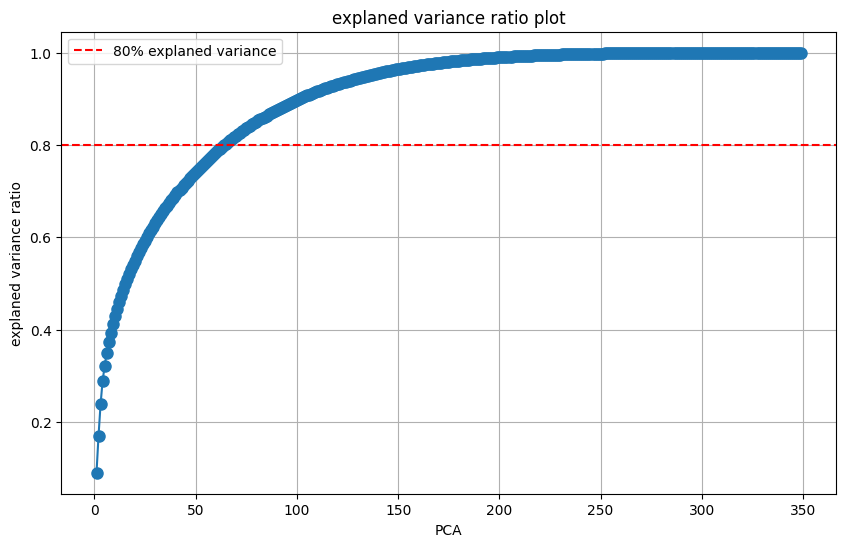

In [36]:
#line1 pca
#line1_train_scaled_df
#line1_test_scaled_df

from sklearn.decomposition import PCA

x_pca = line1_train_scaled_df.drop(columns='Y_Class')
y_pca = line1_train_scaled_df['Y_Class']

pca = PCA()
pca.fit(x_pca)

cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, 'o-', markersize=8)
plt.axhline(y=0.80, color='r', linestyle='--', label='80% explaned variance')
plt.xlabel('PCA')
plt.ylabel('explaned variance ratio')
plt.title('explaned variance ratio plot')
plt.legend()
plt.grid()
plt.show()


In [37]:
line1_train_scaled_df

,X_1,X_2,X_5,X_7,X_8,X_9,X_11,X_12,X_13,X_15,...,X_925,X_926,X_927,X_928,X_929,X_930,X_931,X_932,X_933,Y_Class
0,-0.069603,1.676550,1.243964,-0.870577,-0.226285,-0.997139,1.006343,1.041738,1.010489,-0.053606,...,0.596240,0.964757,8.812935e-01,0.605077,4.930516e-01,-0.340756,1.057783e+00,6.495214e-01,-2.338850e-01,0
1,-0.069603,1.676550,1.243964,-0.870577,-0.226285,-0.997139,1.017944,1.069594,1.022043,-0.053606,...,0.000000,0.000000,7.307115e-15,0.000000,-1.307905e-14,0.000000,9.569148e-14,-3.432424e-14,-3.442410e-14,0
2,-0.069603,0.457558,1.243964,-0.870577,-0.226285,-0.997139,1.180358,1.259015,1.189570,-0.053606,...,-0.999632,-0.054279,8.812935e-01,0.822380,8.528272e-01,1.483599,1.057783e+00,8.718379e-01,-2.338850e-01,1
3,-0.069603,-0.030038,-0.803882,1.190073,-0.226285,1.002869,-1.139838,-1.170035,-1.046044,-0.053606,...,-0.607664,-1.014044,-2.499301e-01,0.822380,1.488710e+00,1.711644,1.057783e+00,9.965012e-01,1.704019e+00,1
4,-0.069603,1.188953,1.243964,-0.870577,-0.226285,-0.997139,1.128153,1.259015,1.108695,-0.053606,...,0.176273,0.578979,4.185202e-01,0.822380,1.141484e+00,1.483599,1.057783e+00,2.485209e-01,-2.338850e-01,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
344,-0.239475,-1.980425,-0.803882,0.274229,-0.226285,1.002869,-1.806894,-1.833010,-1.820132,-0.053606,...,-0.299689,0.172405,5.858544e-02,0.605077,1.455242e+00,1.483599,-7.378679e-01,-1.878011e-01,-2.338850e-01,1
345,-0.069603,0.701357,-0.803882,-0.870577,-0.226285,-0.997139,0.490100,0.401048,0.606115,-0.053606,...,-1.139621,-0.550279,3.287582e-02,0.605077,1.225153e+00,1.483599,-7.378679e-01,-9.357817e-01,-2.338850e-01,1
346,-0.069603,-0.030038,-0.803882,0.274229,-0.226285,1.002869,-1.632879,-1.643589,-1.681490,-0.053606,...,0.148275,0.385570,3.928106e-01,0.822380,1.430142e+00,1.483599,-7.378679e-01,-1.122777e+00,-2.338850e-01,1
347,6.385512,-0.273837,1.243964,-0.870577,-0.226285,-0.997139,0.507501,0.417761,0.507910,-0.053606,...,5.271864,6.107767,5.431897e+00,-0.481439,-9.460510e-01,-0.568800,-7.378679e-01,-5.898221e-02,-2.338850e-01,1


In [38]:
#line1_pca
from sklearn.metrics import classification_report

x_pca = line1_train_scaled_df.drop(columns='Y_Class')
y_pca = line1_train_scaled_df['Y_Class']

pca = PCA(n_components=0.8)

line1_train_pca = pca.fit_transform(x_pca)

line1_train_pca_df = pd.DataFrame(line1_train_pca, columns=[f'PC{i+1}' for i in range(line1_train_pca.shape[1])])

line1_train_pca = pd.concat([line1_train_pca_df, y_pca.reset_index(drop=True)], axis=1)

#h2o 변환

line1_train_h2o_pca = h2o.H2OFrame(line1_train_pca)

line1_train_h2o_pca['Y_Class'] = line1_train_h2o_pca['Y_Class'].asfactor()


aml1_pca = H2OAutoML(max_runtime_secs=120, seed=42, exclude_algos=None, include_algos= None)
aml1_pca.train(y='Y_Class', training_frame = line1_train_h2o_pca)


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |
19:40:52.316: AutoML: XGBoost is not available; skipping it.

███████████████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2ODeepLearningEstimator : Deep Learning
Model Key: DeepLearning_grid_1_AutoML_3_20240824_194052_model_6


Status of Neuron Layers: predicting Y_Class, 3-class classification, multinomial distribution, CrossEntropy loss, 1,383 weights/biases, 26.1 KB, 1,130,760 training samples, mini-batch size 1
    layer    units    type              dropout    l1    l2    mean_rate              rate_rms              momentum    mean_weight           weight_rms           mean_bias            bias_rms
--  -------  -------  ----------------  ---------  ----  ----  ---------------------  --------------------  ----------  --------------------  -------------------  -------------------  -----------------
    1        65       Input             0.0
    2        20       RectifierDropout  40.0       0.0   0.0   0.0014224597202365447  0.002174088731408119  0.0         -0.00793188509459679  0.20668119192123413  0.10793979881220231  0.50046706199646
    3        3        Softmax                      0.0   0.0   0.016225626570909906   0.05269792675971985   0.0         -0.2551068391650915   1.7604069709777832   -0.605068807243899   1.034696102142334

ModelMetricsMultinomial: deeplearning
** Reported on train data. **

MSE: 0.0005213214823832382
RMSE: 0.022832465534480463
LogLoss: 0.0052233364296521215
Mean Per-Class Error: 0.0
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
0    1    2    Error    Rate
---  ---  ---  -------  -------
28   0    0    0        0 / 28
0    289  0    0        0 / 289
0    0    32   0        0 / 32
28   289  32   0        0 / 349

Top-3 Hit Ratios: 
k    hit_ratio
---  -----------
1    1
2    1
3    1

ModelMetricsMultinomial: deeplearning
** Reported on cross-validation data. **

MSE: 0.34060116172331695
RMSE: 0.5836104537474607
LogLoss: 1.7969771331837439
Mean Per-Class Error: 0.5606154226396441
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
0    1    2    Error     Rate
---  ---  ---  --------  ---------
15   12   1    0.464286  13 / 28
91   190  8    0.342561  99 / 289
12   16   4    0.875     28 / 32
118  218  13   0.401146  140 / 349

Top-3 Hit Ratios: 
k    hit_ratio
---  -----------
1    0.598854
2    0.865329
3    1

Cross-Validation Metrics Summary: 
                         mean       sd         cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid
-----------------------  ---------  ---------  ------------  ------------  ------------  ------------  ------------
accuracy                 0.599669   0.268154   0.371429      0.442857      0.9           0.4           0.884058
aic                      nan        0          nan           nan           nan           nan           nan
auc                      nan        0          nan           nan           nan           nan           nan
err                      0.400331   0.268154   0.628571      0.557143      0.1           0.6           0.115942
err_count                28         18.8016    44            39            7             42            8
loglikelihood            nan        0          nan           nan           nan           nan           nan
logloss                  1.79595    0.442926   2.20978       2.2053        1.24107       1.88764       1.43594
max_per_class_error      0.919444   0.0763257  0.833333      

In [39]:
#pca best model
best_model_pca1 = aml1_pca.leader
print(best_model_pca1)

Model Details
H2ODeepLearningEstimator : Deep Learning
Model Key: DeepLearning_grid_1_AutoML_3_20240824_194052_model_6


Status of Neuron Layers: predicting Y_Class, 3-class classification, multinomial distribution, CrossEntropy loss, 1,383 weights/biases, 26.1 KB, 1,130,760 training samples, mini-batch size 1
    layer    units    type              dropout    l1    l2    mean_rate              rate_rms              momentum    mean_weight           weight_rms           mean_bias            bias_rms
--  -------  -------  ----------------  ---------  ----  ----  ---------------------  --------------------  ----------  --------------------  -------------------  -------------------  -----------------
    1        65       Input             0.0
    2        20       RectifierDropout  40.0       0.0   0.0   0.0014224597202365447  0.002174088731408119  0.0         -0.00793188509459679  0.20668119192123413  0.10793979881220231  0.50046706199646
    3        3        Softmax                   

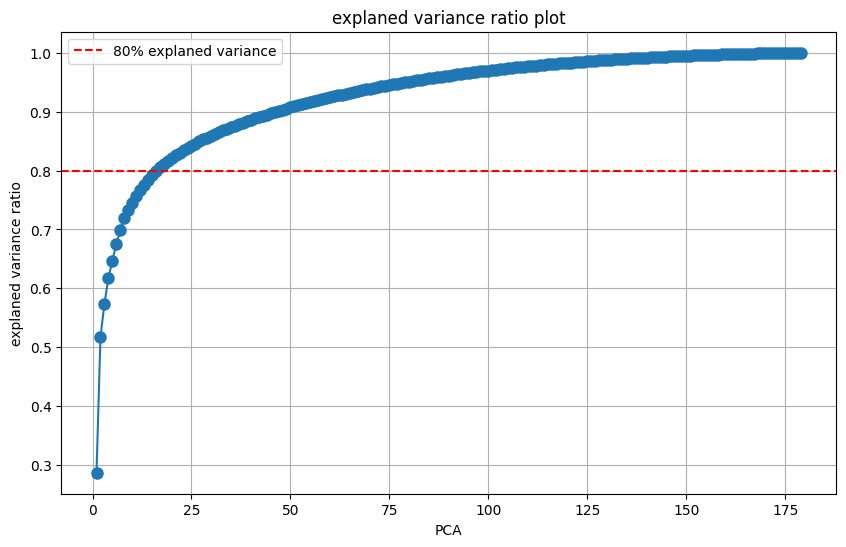

In [40]:
#line2 pca

x_line2_pca = line2_train_scaled_df.drop(columns='Y_Class')
y_line2_pca = line2_train_scaled_df['Y_Class']

pca = PCA()
pca.fit(x_line2_pca)

cumulative_explained_variance_2 = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_explained_variance_2) + 1), cumulative_explained_variance_2, 'o-', markersize=8)
plt.axhline(y=0.80, color='r', linestyle='--', label='80% explaned variance')
plt.xlabel('PCA')
plt.ylabel('explaned variance ratio')
plt.title('explaned variance ratio plot')
plt.legend()
plt.grid()
plt.show()


In [41]:
line2_pca = PCA(n_components=0.85)

line2_train_pca = pca.fit_transform(x_line2_pca)

line2_train_pca_df = pd.DataFrame(line2_train_pca, columns=[f'PC{i+1}' for i in range(line2_train_pca.shape[1])])

line2_train_pca = pd.concat([line2_train_pca_df, y_line2_pca.reset_index(drop=True)], axis=1)

#h2o 변환

line2_train_h2o_pca = h2o.H2OFrame(line2_train_pca)

line2_train_h2o_pca['Y_Class'] = line2_train_h2o_pca['Y_Class'].asfactor()

aml2_pca = H2OAutoML(max_runtime_secs=120, seed=42, exclude_algos=None, include_algos= None)
aml2_pca.train(y='Y_Class', training_frame = line2_train_h2o_pca)


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |
19:42:54.642: AutoML: XGBoost is not available; skipping it.

█
19:42:56.645: _min_rows param, The dataset size is too small to split for min_rows=100.0: must have at least 200.0 (weighted) rows, but have only 179.0.

██████████████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OGradientBoostingEstimator : Gradient Boosting Machine
Model Key: GBM_grid_1_AutoML_4_20240824_194254_model_1


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    28                 84                          33851                  5            6            5.9881        7             44            27.3929

ModelMetricsMultinomial: gbm
** Reported on train data. **

MSE: 0.016096379895890064
RMSE: 0.12687150939391423
LogLoss: 0.12049866832180332
Mean Per-Class Error: 0.0
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
0    1    2    Error    Rate
---  ---  ---  -------  -------
54   0    0    0        0 / 54
0    81   0    0        0 / 81
0    0    44   0        0 / 44
54   81   44   0        0 / 179

Top-3 Hit Ratios: 
k    hit_ratio
---  -----------
1    1
2    1
3    1

ModelMetricsMultinomial: gbm
** Reported on cross-validation data. **

MSE: 0.3070205475992695
RMSE: 0.5540943490049952
LogLoss: 0.8640185420660436
Mean Per-Class Error: 0.3887953610175832
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
0    1    2    Error     Rate
---  ---  ---  --------  --------
21   32   1    0.611111  33 / 54
7    71   3    0.123457  10 / 81
5    14   25   0.431818  19 / 44
33   117  29   0.346369  62 / 179

Top-3 Hit Ratios: 
k    hit_ratio
---  -----------
1    0.653631
2    0.916201
3    1

Cross-Validation Metrics Summary: 
                         mean      sd         cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid
-----------------------  --------  ---------  ------------  ------------  ------------  ------------  ------------
accuracy                 0.625556  0.0271029  0.611111      0.611111      0.638889      0.666667      0.6
aic                      nan       0          nan           nan           nan           nan           nan
auc                      nan       0          nan           nan           nan           nan           nan
err                      0.374444  0.0271029  0.388889      0.388889      0.361111      0.333333      0.4
err_count                13.4      0.894427   14            14            13            12            14
loglikelihood            nan       0          nan           nan           nan           nan           nan
logloss                  0.887221  0.0506716  0.961214      0.917293      0.858316      0.838888      0.860397
max_per_class_error      0.673636  0.103672   0.75          0.6           0.6           0.6           0.818182
mean_per_class_accuracy  0.581996  0.0207369  0.594444      0.573737      0.610458      0.574436      0.556902
mean_per_class_error     0.418004  0.0207369  0.405556      0.426263      0.389543      0.425564      0.443098
mse                      0.305658  0.0204698  0.339091      0.307722      0.299702      0.284476      0.297298
pr_auc                   nan       0          nan           nan           nan           nan           nan
r2                       0.436023  0.0380791  0.411698      0.471778      0.431312      0.388589      0.4

In [42]:
#pca best model
best_model_pca2 = aml2_pca.leader
print(best_model_pca2)


Model Details
H2OGradientBoostingEstimator : Gradient Boosting Machine
Model Key: GBM_grid_1_AutoML_4_20240824_194254_model_1


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    28                 84                          33851                  5            6            5.9881        7             44            27.3929

ModelMetricsMultinomial: gbm
** Reported on train data. **

MSE: 0.016096379895890064
RMSE: 0.12687150939391423
LogLoss: 0.12049866832180332
Mean Per-Class Error: 0.0
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model para